### ASSN_4 Sudhansh_Chopda

# On-chain Theft Forensic Analysis

In [1]:
# Install necessary libraries
!pip install pandas requests plotly  

# Import required libraries
import pandas as pd  # For working with dataframes and data manipulation
import requests  # For making HTTP requests to Etherscan API
import plotly.graph_objects as go  # For creating interactive plots, including Sankey diagrams
import time  # To handle API rate limits by pausing between requests


###  Exploiter Details:

In [2]:
# Exploiter Wallet Address: The address involved in the exploit, from which funds will be tracked
wallet_address = "0x098B716B8Aaf21512996dC57EB0615e2383E2f96"

# Block Range: The range of blocks to analyze, from start_block to end_block
start_block = 14526165
end_block = 14551589

# Tornado Cash Address: The target address for identifying fund transfers to Tornado Cash
tornado_cash_address = "0xd90e2f925da726b50c4ed8d0fb90ad053324f31b"

# Etherscan API Key: A unique key to access Etherscan’s API (replace with your own for use)
api_key = "7SAE898S332Y751U41B5E63ZK7W1Y6X2H9"

# Etherscan API URL: The base URL to access data via Etherscan API
api_url = "https://api.etherscan.io/api"

### Fetching the transactions Data for a specified wallet and block range using the given API.

In [3]:
# Function to fetch transactions for a specified wallet address and block range
def fetch_wallet_transactions(wallet_address, start_block, end_block, api_key, api_url):
   
    # Construct the URL to query Etherscan's API for transaction data
    url = f"{api_url}?module=account&action=txlist&address={wallet_address}&startblock={start_block}&endblock={end_block}&sort=asc&apikey={api_key}"
    
    # Send the request to Etherscan API
    response = requests.get(url)
    
    # Check if the response is successful (status code 200)
    if response.status_code == 200:
        # Return the 'result' from the API response, or an empty list if no results
        return response.json().get('result', [])
    else:
        # Raise an error if the API request fails
        raise Exception(f"API request failed with status code: {response.status_code}")


# Function to filter transactions with values greater than or equal to a specified threshold (default is 100 ETH)
def filter_large_transactions(transactions, min_value=100):

    # Convert the list of transactions into a pandas DataFrame for easier manipulation
    transaction_df = pd.DataFrame(transactions)
    
    # Convert the 'value' from Wei (smallest unit of Ether) to ETH (1 ETH = 10^18 Wei) and handle errors
    transaction_df['value'] = pd.to_numeric(transaction_df['value'], errors='coerce', downcast='float') / 10**18
    
    # Drop any rows where the 'value' column is NaN (caused by invalid or missing data)
    transaction_df = transaction_df.dropna(subset=['value'])
    
    # Filter the transactions where the value is greater than or equal to the threshold (min_value)
    filtered_transactions = transaction_df[transaction_df['value'] >= min_value]
    
    # Return only the relevant columns for analysis: 'from', 'to', 'value', and 'hash'
    return filtered_transactions[['from', 'to', 'value', 'hash']]


# Function to save the filtered transactions to a CSV file
def save_to_csv(dataframe, file_name):

    # Save the DataFrame to a CSV file without including the index column
    dataframe.to_csv(file_name, index=False)
    print(f"Data saved to {file_name}")  # Print confirmation that data was saved

### Tracking the flow of funds

In [4]:



# Function to track the flow of funds from a starting wallet address to subsequent addresses up to a specified depth
def track_wallet_funds(start_address, max_hops=2, block_start=start_block, block_end=end_block, 
                       api_key=api_key, api_url=api_url, tornado_cash_address=tornado_cash_address, 
                       output_file="fund_flow_analysis.csv"):
  
    collected_txns = []  # Initialize a list to collect all relevant transactions
    current_addresses = [start_address]  # Start with the given wallet address
    
    # Loop over each depth/hop level (up to max_hops)
    for depth in range(max_hops):
        print(f"Processing depth {depth + 1}...")
        next_addresses = []  # List to collect addresses for the next hop

        # Iterate over all addresses in the current depth to fetch transactions
        for address in current_addresses:
            try:
                # Fetch transactions for the current address within the specified block range
                transactions = fetch_wallet_transactions(address, block_start, block_end, api_key, api_url)
                
                # Filter out transactions that are below the minimum threshold (100 ETH by default)
                filtered_txns = filter_large_transactions(transactions)
                
                # Add the filtered transactions to the collected transactions list
                collected_txns.extend(filtered_txns.to_dict('records'))
                
                # Check if any funds are going to Tornado Cash and stop tracking that flow
                if tornado_cash_address and tornado_cash_address in filtered_txns['to'].values:
                    print(f"Funds detected going to Tornado Cash from {address}.")
                    continue  # Stop tracking this chain of funds
                
                # Collect unique recipient addresses for the next depth iteration
                next_addresses.extend(filtered_txns['to'].unique())
            
            except Exception as e:
                print(f"Error processing address {address}: {e}")  # Handle any errors for specific addresses

        # Update the list of addresses for the next hop
        current_addresses = next_addresses

    # Convert the collected transactions into a pandas DataFrame for analysis
    fund_flow_df = pd.DataFrame(collected_txns)

    # Save the fund flow data to a CSV file
    save_to_csv(fund_flow_df, output_file)
    return fund_flow_df  # Return the DataFrame containing the fund flow data


# Start the fund tracking process
try:
    # Call the function to track the funds starting from the Exploiter address, following up to 2 hops
    tracked_fund_data = track_wallet_funds(
        start_address=wallet_address,
        max_hops=2  # Set maximum hops (depth) to 2 for this analysis
    )
    print("Fund tracking complete. Data saved to file.")
except Exception as e:
    print(f"An error occurred during fund tracking: {e}")  # Catch any errors that occur during the tracking process


Processing depth 1...
Processing depth 2...
Funds detected going to Tornado Cash from 0x429a66e7bd829f9453cee5239bfeaf5657a11a3e.
Funds detected going to Tornado Cash from 0x5b0431365ce1ab3693bea6f33ae67653dd30d8bd.
Funds detected going to Tornado Cash from 0xbcd78c2d608e7ceb3d25bea30fae8a9d57033868.
Data saved to fund_flow_analysis.csv
Fund tracking complete. Data saved to file.


### Summary of the funds 

In [5]:
def summarize_funds(dataframe, tornado_cash_address=None, top_n=10):
    
    # Group by recipient address ('to') and sum the values of transactions sent to each recipient
    recipient_summary = dataframe.groupby('to')['value'].sum().reset_index()

    # Initialize tornado_total to 0 (we will update it if Tornado Cash address is provided)
    tornado_total = 0

    # If a Tornado Cash address is provided, calculate the total funds sent to that address
    if tornado_cash_address:
        # Filter for rows where the recipient is the Tornado Cash address and sum the 'value' column
        tornado_total = recipient_summary[recipient_summary['to'] == tornado_cash_address]['value'].sum()
        # Print the total funds sent to Tornado Cash
        print(f"Total funds sent to Tornado Cash: {tornado_total} ETH")

    # Sort the recipient summary by value (descending order) and get the top N recipients
    top_recipients = recipient_summary.sort_values(by='value', ascending=False).head(top_n)
    
    # Print the top N recipients
    print("Top Recipients:")
    print(top_recipients)

    # Return the recipient summary, total funds sent to Tornado Cash, and the top N recipients
    return recipient_summary, tornado_total, top_recipients


# Example usage: Summarize the funds based on the tracked data (ensure 'tracked_fund_data' is already populated)
recipient_summary, tornado_total, top_recipients = summarize_funds(
    dataframe=tracked_fund_data,  # Use the DataFrame containing the tracked fund flow data
    tornado_cash_address=tornado_cash_address,  # Pass the Tornado Cash address to track funds
    top_n=10  # Get the top 10 recipients by the total funds they received
)


Total funds sent to Tornado Cash: 7900.0 ETH
Top Recipients:
                                           to        value
5  0xd90e2f925da726b50c4ed8d0fb90ad053324f31b  7900.000000
4  0xbcd78c2d608e7ceb3d25bea30fae8a9d57033868  6205.243000
1  0x1361c1e18930483f4aaf91f3a263937e4fcc1f39  6005.970000
3  0x5b0431365ce1ab3693bea6f33ae67653dd30d8bd  5606.512200
2  0x429a66e7bd829f9453cee5239bfeaf5657a11a3e  4036.470580
6  0xdf225c84a0eaeaaac20e6c1d369e94ee13b9df2a  3498.431280
0  0x01a5d51057a82818d68d8f3b76ef0ac69a99a911  1774.675338


### Visualizing the Findings

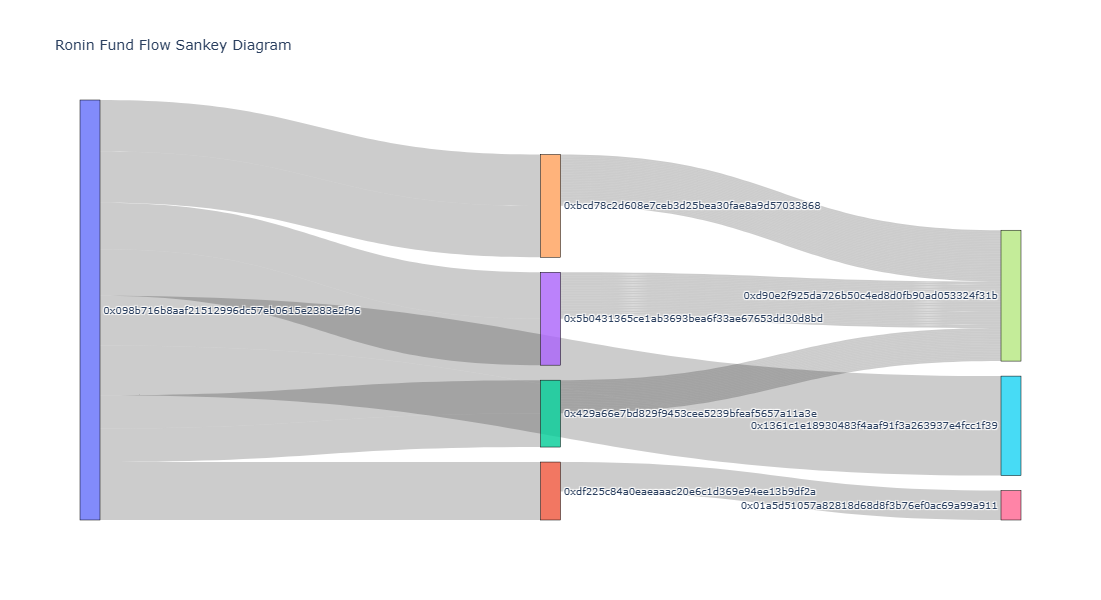

In [13]:
import plotly.graph_objects as go


# Rename it to fund_tracking_data for consistency with your visualization code
fund_tracking_data = tracked_fund_data 

# Clean up the data to ensure the 'from', 'to', and 'value' columns are valid and not missing
fund_tracking_data = fund_tracking_data.dropna(subset=['from', 'to', 'value'])  # Remove rows with missing values in these columns
fund_tracking_data['value'] = pd.to_numeric(fund_tracking_data['value'], errors='coerce')  # Ensure 'value' is numeric (ETH amounts)

# Create a list of unique nodes (addresses involved in the fund flow)
nodes = pd.concat([fund_tracking_data['from'], fund_tracking_data['to']]).unique()

# Create a mapping from each node (address) to a unique index
node_indices = {node: i for i, node in enumerate(nodes)}

# Prepare the data for the Sankey diagram (map addresses to indices and keep transaction values)
sankey_data = {
    'source': fund_tracking_data['from'].map(node_indices),  # Map 'from' addresses to node indices
    'target': fund_tracking_data['to'].map(node_indices),    # Map 'to' addresses to node indices
    'value': fund_tracking_data['value']  # The amount of ETH transferred in each transaction
}

# Create a Sankey diagram using Plotly
fig = go.Figure(go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=nodes  # Display full addresses in nodes
    ),
    link=dict(
        source=sankey_data['source'],
        target=sankey_data['target'],
        value=sankey_data['value'],
        # Add hovertemplate to display full addresses and value
        hovertemplate='From: %{source.label}<br>To: %{target.label}<br>Value: %{value} ETH<extra></extra>' 
    )
))


fig.update_layout(
    title_text="Ronin Fund Flow Sankey Diagram",
    font_size=10,
    # Adjust width and height for better address display - Corrected indentation
    width=1000, 
    height=600  
)


# Display the Sankey diagram
fig.show()
